# ImageClassification-AI: Modelo S 
### Versão B

Modelo de raiz com o intuito de obter os melhores resultados possívels. Por consequência, este modelo vai almejar otimizar ao máximo a sua arquitetura.

### 1. Setup

#### 1.1 Importar dependências

Importação das bibliotecas necessárias para o desenvolvimento do modelo.

São de notar as bibliotecas:
* Tensorflow e Keras, que vão ser utilizadas na construção do modelo e no seu processo de treino

* Matplotlib (em específico o pyplot), Seaborn e sklearn, que vão ser utilizadas para facilitar a análise e a compreensão das métricas atribuidas ao modelo, da sua evolução, e dos resultados obtidos

* Image_dataset_from_directory (através do keras.utils), numpy e OS para o carregamento e tratamento dos dados

In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from keras.utils import image_dataset_from_directory
from tensorflow import keras
from keras import layers, regularizers, optimizers
from sklearn.metrics import confusion_matrix, classification_report

#### 1.2 Desativar warnings do Tensorflow

Para desenvolvimento deste modelo foi utilizada a versão 2.10.0 do Tensorflow. Devido a este facto, ficou compreendido que seria beneficial desativar as mensagens de warning dadas pelo Tensorflow, deixando apenas as mensagens de erro, com o intuito de melhorar substancialmente a legibilidade do notebook. É importante realçar que, nenhuma das mensagens de aviso que serão desativadas, em algum momento afetam qualquer aspeto do modelo ou sequer ajudam a compreender potenciais problemas com este.

In [2]:
tf.get_logger().setLevel('ERROR')

#### 1.3 Tratamento de dados

Definição das classes do problema:

* Tamanho das imagens RGB (32x32x3 pixeis) 
* Tamanho de cada batch (32)
* Diretorias dos datasets de treino, validação e teste

Para a criação dos datasets é utilizado o image_dataset_from_directory com os paramêtros relativos à diretoria onde estão as imagens, o tamanho destas, o tamanho de cada batch, a definição das labels como categorical (requerido devido ao facto do problema em questão envolver 10 classes; as labels serão uma tensor float32 de tamanho (batch_size, num_classes), que iram representar, cada, um one-hot encoding de cada index de cada classe). 

Aqui é, ainda, importar notar:

* O dataset de treino está a ser baralhado de modo a que, durante o processo de treino, o modelo não decore padrões nas imagens de treino. Para além disso, é relevante perceber que o dataset de treino é construido através da concatenação de quatro datasets de treino mais pequenos (cada um relativo a uma das diretoria de treino)

* Os datasets de validação e de testes não são baralhados. Ao baralhar o dataset de treino a análise dos resultados obtidos pelo modelo seria extremamente dificultada (e.g. ao construir um classification report para este dataset os resultados seriam incorretos porque as labels não iriam corresponder) No que toca ao dataset de validação, a questão entre baralhar ou não acaba por ser irrelevante já que não existe nenhum tipo de benefício para o fazer. Isto foi confirmado por uma pesquisa sobre o assunto e por tentativas de treino do modelo com o dataset de validação baralhado e sem estar baralhado (os resultados eram os mesmo)

In [3]:
class_names = []

IMG_SIZE = 32
BATCH_SIZE = 32

train_dirs = ['train1', 'train2', 'train3', 'train5']
val_dir = 'train4'
test_dir = 'test'

print("BUILDING TRAIN DATASET...")
train_dataset_list = []
for td in train_dirs:
    train_dataset_list.append(image_dataset_from_directory(td, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, label_mode='categorical', shuffle=True, color_mode='rgb'))

train_dataset = train_dataset_list[0]
for name in train_dataset_list[0].class_names:
    idx = name.index('_') + 1
    class_names.append(name[idx:])

for d in train_dataset_list[1:]:
    train_dataset = train_dataset.concatenate(d)

print("\nBUILDING VALIDATION DATASET...")
val_dataset = image_dataset_from_directory(val_dir, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, label_mode='categorical', shuffle=False,color_mode='rgb')

print("\nBUILDING TEST DATASET...")
test_dataset = image_dataset_from_directory(test_dir, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, label_mode='categorical', shuffle=False, color_mode='rgb')

BUILDING TRAIN DATASET...
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.

BUILDING VALIDATION DATASET...
Found 10000 files belonging to 10 classes.

BUILDING TEST DATASET...
Found 10000 files belonging to 10 classes.


### 2. Visualização

#### 2.1 - Classes e número de imagens

Visualização das classes que envolvem o problema e da quantidade de imagens contidas em cada dataset

In [4]:
print("\nClasses: " + str(class_names))

total_train = 0
for td in train_dirs:
    class_folders = next(os.walk(td))[1]
    for cf in class_folders:
        total_train += len(os.listdir(os.path.join(td, cf)))

total_val = 0
class_folders = next(os.walk(val_dir))[1]
for folder in class_folders:
    folder_path = os.path.join(val_dir, folder)
    total_val += len(os.listdir(folder_path))

total_test = 0
class_folders = next(os.walk(test_dir))[1]
for folder in class_folders:
    folder_path = os.path.join(test_dir, folder)
    total_test += len(os.listdir(folder_path))

print("Dataset de treino: " + str(total_train) + " imagens")
print("Dataset de validação: " + str(total_val) + " imagens")
print("Dataset de teste: " + str(total_test) + " imagens")


Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Dataset de treino: 40000 imagens
Dataset de validação: 10000 imagens
Dataset de teste: 10000 imagens


#### 2.2 Tamanhos

Visualização dos tamanhos:
* Cada batch tem 32 imagens
* Cada imagem RGB tem 32x32 pixeis (32x32x3)
* Cada batch de labels tem 10 classes

In [5]:
for data_batch, label_batch in train_dataset:
    print('Shape de cada data batch: ', data_batch.shape)
    print('Shape de cada label batch: ', label_batch.shape)
    break

Shape de cada data batch:  (32, 32, 32, 3)
Shape de cada label batch:  (32, 10)


#### 2.3 - Normalização

Visualização da normalização dos pixeis:
* Divisão do valor de cada pixel por 255
* Operação definida, posteriormente, na construção do modelo e, feita durante o processo de treino para cada imagem de modo a que, cada pixel tenha um valor associado que pertença ao intervalo de [0,1].
* Mostrar como o modelo irá interpretar cada imagem (os valores de cada pixel)

In [6]:
iterator = train_dataset.as_numpy_iterator()
batch = iterator.next()
batch[0] / 255 # normalizar (feito mais à frente relo rescalling)

array([[[[0.4509804 , 0.58431375, 0.7490196 ],
         [0.4627451 , 0.59607846, 0.7647059 ],
         [0.4627451 , 0.6       , 0.7647059 ],
         ...,
         [0.39607844, 0.5372549 , 0.7529412 ],
         [0.39215687, 0.5294118 , 0.74509805],
         [0.3764706 , 0.5176471 , 0.73333335]],

        [[0.4862745 , 0.60784316, 0.7529412 ],
         [0.49411765, 0.6156863 , 0.7607843 ],
         [0.49803922, 0.61960787, 0.7647059 ],
         ...,
         [0.42352942, 0.5568628 , 0.75686276],
         [0.41568628, 0.54901963, 0.7490196 ],
         [0.4       , 0.53333336, 0.73333335]],

        [[0.5137255 , 0.61960787, 0.7411765 ],
         [0.5254902 , 0.6313726 , 0.7490196 ],
         [0.53333336, 0.6431373 , 0.7607843 ],
         ...,
         [0.4509804 , 0.5803922 , 0.7607843 ],
         [0.44705883, 0.57254905, 0.75686276],
         [0.43137255, 0.5568628 , 0.7411765 ]],

        ...,

        [[0.2627451 , 0.23137255, 0.1882353 ],
         [0.27058825, 0.23921569, 0.19607843]

#### 2.4 - Imagens do dataset de treino

Visualização de dez imagens aleatórias do dataset de treino.

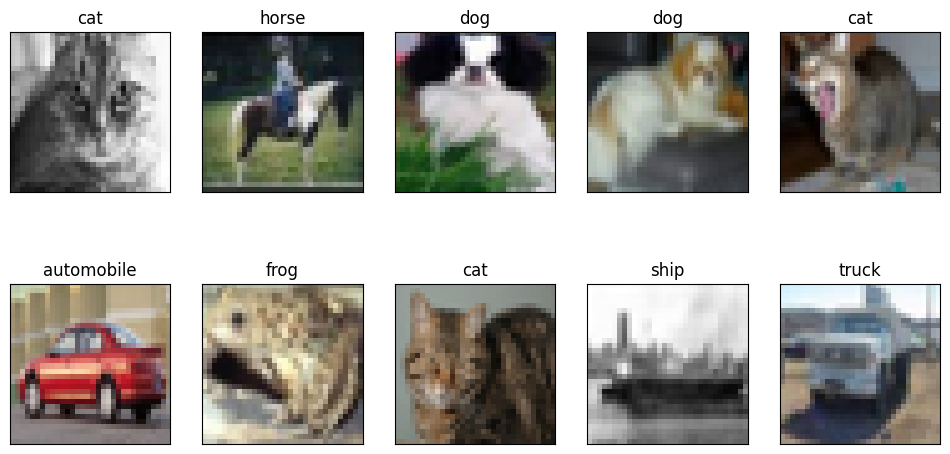

In [7]:
plt.figure(figsize=(12, 6))  # Aumentar o tamanho das imagens no plot

for data_batch, label_batch in train_dataset.take(1):
    for i in range(10):
        plt.subplot(2, 5, i + 1) # mostrar as imagens todas no "mesmo plot" de modo a economizar espaço
        plt.title(class_names[np.argmax(label_batch[i])]) # mostrar a classe da imagem
        plt.imshow(data_batch[i].numpy().astype('uint8'))
        plt.xticks([]) # não mostrar os eixos (irrelevante para a visualização)
        plt.yticks([]) # não mostrar os eixos (irrelevante para a visualização)
    plt.show()

### 3. Modelo

#### 3.1 Definição

A arquitetura deste modelo foi inspirada na arquitetura do modelo VGG16. Com isto, temos:

* Como supramencionado, a normalização dos valores de cada pixel da imagem

* Três blocos de layers convolucionais:
    * Cada um com duas camadas convolucionais:
    * A quantidade de filtros em cada camada convolucional vai aumentado progressivamente de 32 filtros até 128 e mantem-se constante dentro de cada bloco convolucional, isto é, dentro do mesmo bloco os filtros é utilizada a mesma quantidade de filtros para as ambas as camadas
    * É utilizada a função de ativação ReLu
    * No final de cada bloco convolucional é feito o MaxPooling do feature map até aquele momento, com um filtro de 2x2 (que irá reduzir o tamanho de feature map em metade e, no caso de o valor ser decimal, irá arrendondar o tamanho às unidades)
    * Ainda sobre o final de cada bloco convolucional, é utilizado o Dropout() com o valor de 0.2, isto é, ou seja, no final de cada bloco convolucional são excluidos 20% (x * 100 %, sendo x o valor do paramêtro utilizado no Dropout) dos neurónios presentes naquele momento
    * É utilizada a técnica de regularização BatchNormalization com o intuito de manter consistente a distribuição dos valores que saem dos outputs de cada layer e que entram na próxima

*  Bloco de classificação:
    * É utilizado o Flatten para transformar os valores obtidos até aqui num vetor 1D
    * É utilizada uma camada densa com 128 filtros que, irá receber os valores da ultima camada convolucional aos quais vai aplicar a BatchNormalization e a técnica de Dropout
    * É utilizada uma outra camada densa, com 10 filtros (que equivalem ao número de classes presentes no problema), para efetuar a classificação da imagem. Aqui é utilizada a função de ativação "softmax" devido a esta ser mais apropriada a um problema de classificação com várias classes diferentes. Para além disso, é também, utilizado a regularização L2 para, tal como o Dropout, combater o overfitting

É feito um sumário do modelo para melhor compreensão deste, especialmente no que toca ao tamanho dos feature maps em cada ponto e à quantidade de paramêtros que este envolve.

In [8]:
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

x = layers.Rescaling(1./255)(inputs)

# 1st Convolutional Block (2 layers)
x = layers.Conv2D(filters=32, kernel_size=3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.Conv2D(filters=32, kernel_size=3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.2)(x)

# 2nd Convolutional Block (2 layers)
x = layers.Conv2D(filters=64, kernel_size=3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.Conv2D(filters=64, kernel_size=3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.2)(x)

# 3rd Convolutional Block (2 layers)
x = layers.Conv2D(filters=128, kernel_size=3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.Conv2D(filters=128, kernel_size=3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.2)(x)

# Classification Block
x = layers.Flatten()(x)
x = layers.Dense(128)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(10, activation="softmax", kernel_regularizer=regularizers.l2(0.01))(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 552,874 (2.11 MB)

 Trainable params: 551,722 (2.10 MB)

 Non-trainable params: 1,152 (4.50 KB)

#### 3.2 Compilação

É utilizada a função de loss "categorical_crossentropy" devido à natureza do problema (várias classes).
Para analisar o desempenho do modelo são utilizadas metricas de acerto (neste caso o "CategorialAccuracy" em vez do Accuracy normal devido ao contexto do problema), precisão e recall. É, ainda, importante referir que inicialmente era para ser incluida uma métrica de calculo relativo ao F1-Score, mas, devido ao facto de ter sido utilizado o Tensorflow 2.10.0 para treinar os modelos, como supramencionado, não foi possível utilizar esta métrica. Isto acontece porque esta versão do Tensorflow não suporta a referida metrica. Realizaram-se experiências utilizando a métrica F1-Score do Tensorflow Addons mas, os resultados não foram satisfatórios.

Neste modelo foi utilizado como otimizador o Adam, com o principal objetivo de explorar mais otimizadores. Não é definido um learning rate a ser utilizado por este otimizador, sendo utilizado o rate por omissão, já que este já possui, de base, técnicas de otimização do learning rate.

In [9]:
model.compile(
    loss='categorical_crossentropy', 
    optimizer=optimizers.Adam(),
    metrics=[
                tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall'),
            ])

#### 3.3 Processo de treino

São definidas callbacks de:
* EarlyStopping, que vai servir para interromper o processo de treino. É monitorizada a loss no dataset de validação em cada epoch e, se após 10 epochs não houver melhoria desta métrica, então o treino vai ser interrompido

* ModelCheckpoint, que vai permitir guardar o melhor modelo obtido durante o processo de treino (em troca de se guardar o modelo na ultima epoch de treino que, pode não ser necessáriamente o melhor como é o caso de, por exemplo, situações onde o modelo começa a entrar em overfitting). Aqui é definida a diretoria onde guardar o melhor modelo e a metrica de monitorização que, neste caso, volta a ser a loss no dataset de validação. É, também utilizado o verbose para melhorar a compreensão do processo de treino.

Com isto, é, então, realizado o processo de treino (model.fit) utilzando:

* O dataset de treino
* 100 epochs
* O dataset de validação para representar a capacidade de generalização do modelo
* As callbacks de EarlyStopping e ModelCheckpoint definidas

In [10]:
# Definir as callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='models/IC_S_B.keras',
        save_best_only = True,
        monitor='val_loss',
        verbose=1 
    )
]

# Treinar o modelo
history = model.fit(train_dataset, epochs=100, validation_data=val_dataset, callbacks=callbacks)

Epoch 1/100
1251/1252 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.3748 - loss: 1.8981 - precision: 0.5323 - recall: 0.1796
Epoch 1: val_loss improved from inf to 2.18712, saving model to models/IC_S_B.keras
1252/1252 ━━━━━━━━━━━━━━━━━━━━ 82s 61ms/step - accuracy: 0.3749 - loss: 1.8976 - precision: 0.5325 - recall: 0.1797 - val_accuracy: 0.3518 - val_loss: 2.1871 - val_precision: 0.4578 - val_recall: 0.2430
Epoch 2/100
1251/1252 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.6165 - loss: 1.1683 - precision: 0.7774 - recall: 0.4405
Epoch 2: val_loss improved from 2.18712 to 1.48422, saving model to models/IC_S_B.keras
1252/1252 ━━━━━━━━━━━━━━━━━━━━ 81s 65ms/step - accuracy: 0.6165 - loss: 1.1682 - precision: 0.7775 - recall: 0.4405 - val_accuracy: 0.5268 - val_loss: 1.4842 - val_precision: 0.6353 - val_recall: 0.4321
Epoch 3/100
1252/1252 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.6811 - loss: 0.9808 - precision: 0.8036 - recall: 0.5500
Epoch 3: val_loss improved from 1.48422 t

#### 3.4 Avaliação

O melhor modelo obtido durante o processo de treino é carregado e avaliado utilizando o dataset de teste. Aqui são mostrados os valores das métricas de accuracy, loss, precision e recall obtidas pelo modelo nas imagens de teste.

In [11]:
# Carregar o modelo
model = keras.models.load_model('models/IC_S_B.keras')

# Avaliar o modelo
test_loss, test_acc, test_precision, test_recall = model.evaluate(test_dataset)

print("Test Accuracy: " + str(test_acc))
print("Test Loss: " + str(test_loss))
print("Test Precision: " + str(test_precision))
print("Test Recall: " + str(test_recall))

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8549 - loss: 0.4925 - precision: 0.8801 - recall: 0.8323
Test Accuracy: 0.8458999991416931
Test Loss: 0.5175831913948059
Test Precision: 0.8727716207504272
Test Recall: 0.8224999904632568


### 4. Análise dos resultados

#### 4.1 Evolução das métricas durante o processo de treino

São utilizados gráficos para melhor compreender de que maneira as métricas, nomeadamente a accuracy, loss, precision e recall, foram evoluindo ao longo do processo de treino.

É possível visualizar que:

* O modelo começa a entrar em overfitting por volta da época 20 

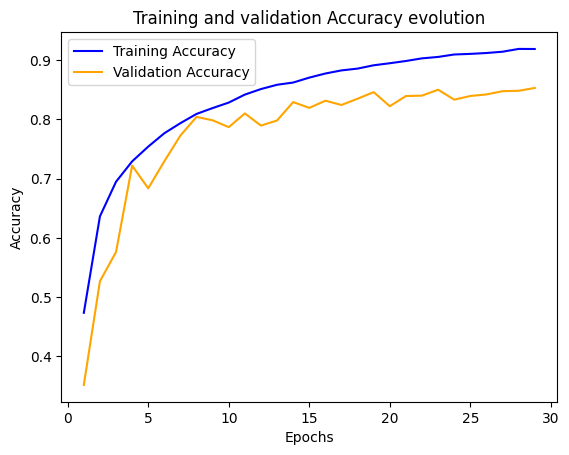

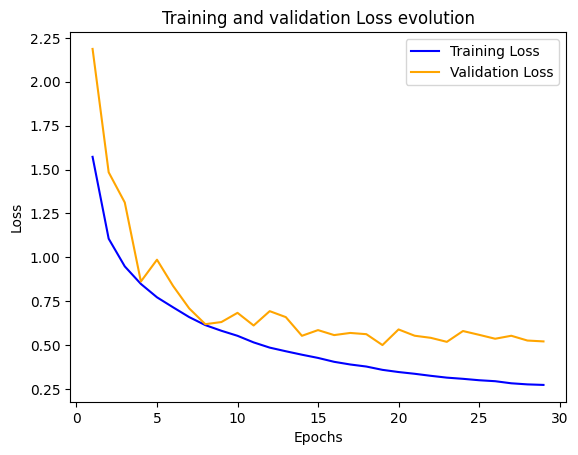

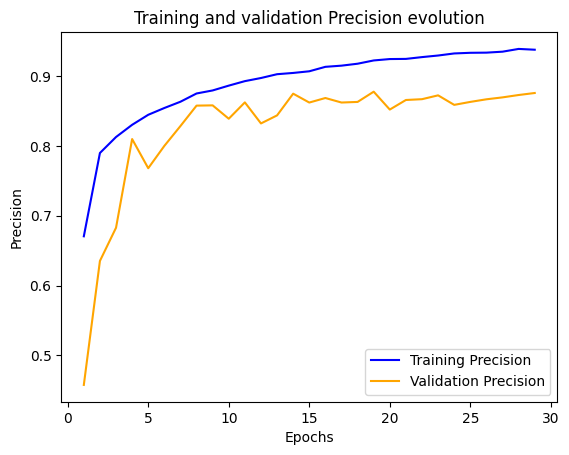

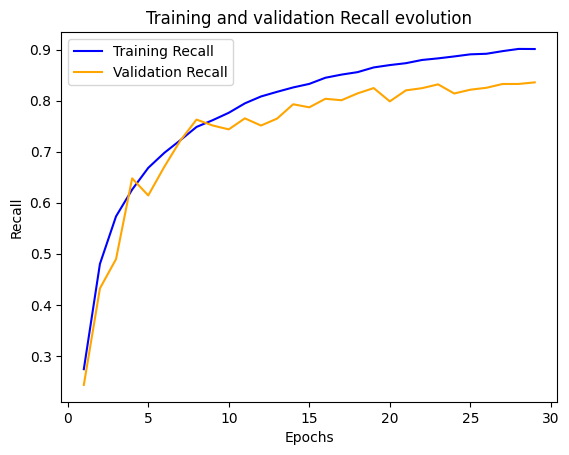

In [12]:
# Buscar as métricas
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
precision = history.history['precision']
val_precision = history.history['val_precision']
recall = history.history['recall']
val_recall = history.history['val_recall']

# Calcular o número de épocas que foram realizadas
epochs = range(1, len(acc) + 1)

# Gráfico da accuracy
plt.plot(epochs, acc, 'blue', label='Training Accuracy')
plt.plot(epochs, val_acc, 'orange', label='Validation Accuracy')
plt.title('Training and validation Accuracy evolution')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()

# Gráfico da loss
plt.plot(epochs, loss, 'blue', label='Training Loss')
plt.plot(epochs, val_loss, 'orange', label='Validation Loss')
plt.title('Training and validation Loss evolution')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.figure()

# Gráfico da precision
plt.plot(epochs, precision, 'blue', label='Training Precision')
plt.plot(epochs, val_precision, 'orange', label='Validation Precision')
plt.title('Training and validation Precision evolution')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.figure()

# Gráfico do recall
plt.plot(epochs, recall, 'blue', label='Training Recall')
plt.plot(epochs, val_recall, 'orange', label='Validation Recall')
plt.title('Training and validation Recall evolution')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.show()

#### 4.2 Desempenho no dataset de teste

De modo a compreender o real desempenho do modelo precisamos avaliar este utilizando o dataset de teste (que contém imagens que o este nunca viu anteriormente).

São feitas, e guardadas, previsões do modelo sobre o dataset de teste para, posteriormente, ser criado um classification report, que nos vai permitir analisar a taxa de acerto global e a precision, recall e f1-score para cada classe. Para além disso, é, também, construida uma matriz de confusão que, vai permitir ilustrar de uma outra maneira as previsões (vai ser possível ver, por exemplo, que quando a imagem pertencia à classe "dog", o modelo achou n vezes que a imagem pertencia à classe "cat").

Com isto, podemos compreender que:

* O modelo obtem resultados bastante satisfatórios

* É possível perceber que existe alguma dificuldade em classificar certas classes, especialmente quando comparamos os resultados obtidos nestas com os obtidos nas outras. Estas classes são:
    * Bird
    * Cat
    * Dog


313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step
              precision    recall  f1-score   support

    airplane       0.79      0.92      0.85      1000
  automobile       0.91      0.95      0.93      1000
        bird       0.82      0.76      0.79      1000
         cat       0.78      0.64      0.70      1000
        deer       0.80      0.85      0.83      1000
         dog       0.79      0.78      0.78      1000
        frog       0.86      0.90      0.88      1000
       horse       0.85      0.89      0.87      1000
        ship       0.95      0.86      0.90      1000
       truck       0.92      0.91      0.92      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.84     10000
weighted avg       0.85      0.85      0.84     10000



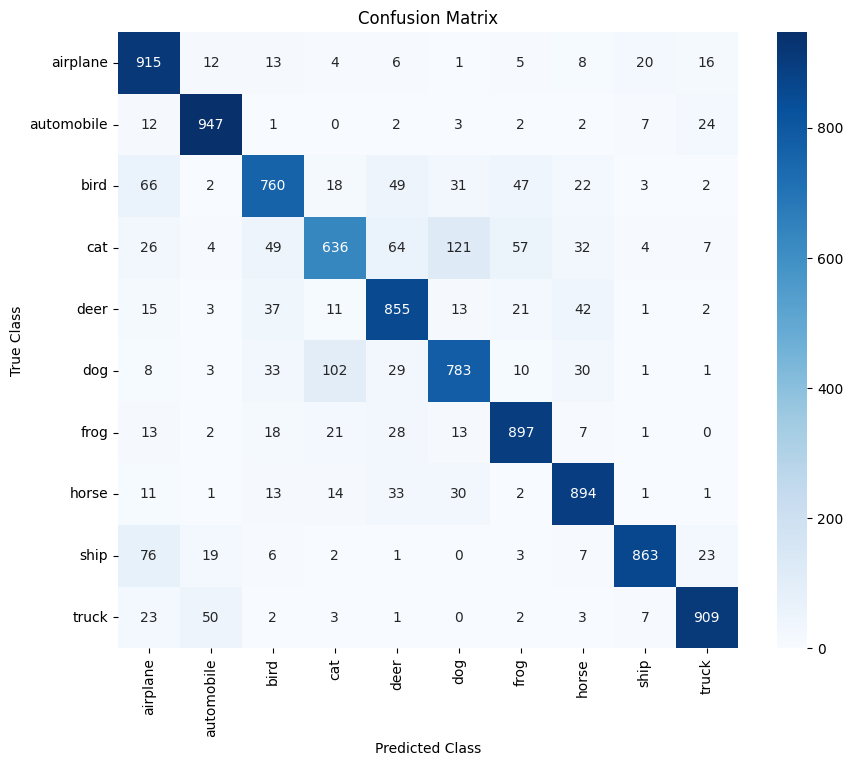

In [13]:
# Fazer previsões para o dataset de teste
predictions = model.predict(test_dataset)
predicted_classes = np.argmax(predictions, axis=1)

# Obter as classes verdadeiras de cada imagem no dataset de teste
true_classes = []
for images, labels in test_dataset:
    true_classes.extend(np.argmax(labels.numpy(), axis=1))
true_classes = np.array(true_classes)

# Criar o classification report
report = classification_report(true_classes, predicted_classes, target_names=class_names)
print(report)

# Mostrar a matriz de confusão
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

#### 4.3 Visualização de previsões

Aqui fazemos a visualização de imagens tal como anteriormente, mas introduzimos a previsão do modelo para cada uma das imagens, sendo possível visualizar, também, a classe real de cada imagem.

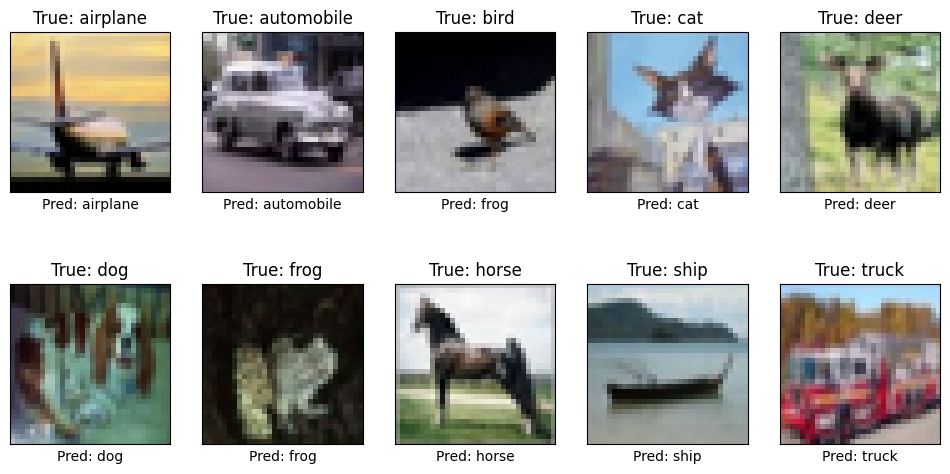

In [14]:
displayed_classes = set()

plt.figure(figsize=(12, 6))  # Ajustar o tamanho das imagens

for data_batch, label_batch in test_dataset:
    for i in range(len(label_batch)):
        true_class_idx = np.argmax(label_batch[i])
        true_label = class_names[true_class_idx]
        
        if true_class_idx not in displayed_classes:
            displayed_classes.add(true_class_idx)
            
            plt.subplot(2, 5, len(displayed_classes))
            
            pred_label = model.predict(np.expand_dims(data_batch[i], axis=0), verbose=0)
            pred_label = class_names[np.argmax(pred_label)]

            plt.title("True: " + true_label)
            plt.xlabel("Pred: " + pred_label)
            plt.imshow(data_batch[i].numpy().astype('uint8'))
            plt.xticks([])
            plt.yticks([])
        
        # Stop condition para no caso de já terem sido mostrada 10 imagens
        if len(displayed_classes) == 10:
            break
    if len(displayed_classes) == 10:
        break

plt.show()

### Conclusões

O modelo tem um pequeno problema de overfitting já que, a partir da época 20, não há nenhuma melhoria. É expectável que ao treinar o modelo utilizando a técnica de Data Augmentation este problema acabe por ser mitigado.

Também relacionado com o overfitting está o espaço para melhoria que existe na classificação das classes Bird, Cat e Dog. Apesar de ser considerar que os resultados obtidos para essas classes são satisfatórios existe, um claro espaço para melhoria neste aspeto do modelo. Uma das maneiras que em que isto pode ser realizado é com a utilização de mais camadas convolucionais ou de mais filtros na arquitetura do modelo, com o objetivo de aumentar a capacidade de reconhecimento de features especificas das classes mencionadas por parte do modelo.

É importante realçar que, o modelo também foi treinado utilizando um scheduler para o learning rate e o Optuna, um algoritmo de otimização dos hyperparameters. Os resultados que foram obtidos nestes treinos não foram satisfatórios e, foi tomada a decisão de remover estes dois do modelo final. Em ambos os casos o modelo não melhorava significativamente, sendo que, no caso do scheduler, verificámos que o modelo perdia demasiada capacidade de convergência e, no caso do Optuna, o modelo não foi capaz de obter resultados significativamente melhores no que toca às métricas de classificação. Tanto o scheduler como o Optuna aumentavam substancialmente o tempo de treino do modelo, o que contribui-o considerávelmente para a decisão de não utilizar estes. Por fim, no caso específico do Optuna é importante realçar que foram, também, feitas experiências utilizando um timeout entre dez e trinta minutos, com o intuito de reduzir o tempo necessário para o treino do modelo, que chegou a resultar em treinos onde o modelo obtinha resultados piores.

### Bibliografia

https://www.markdownguide.org/basic-syntax/

https://www.tensorflow.org/

https://keras.io/api/applications/

https://keras.io/api/optimizers/

https://keras.io/api/data_loading/

https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/

https://nchlis.github.io/2017_08_10/page.html

https://towardsdatascience.com/a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-ii-hyper-parameter-42efca01e5d7